In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import gc

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from fastai.vision.all import *
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 5
FOLDS = [1,2,3,4,5]
PATH = 'C:/Users/TCrepin/perso/Projects/RSNA-Lumbar-Spine-Conditions-Severity-Prediction/' # Main path
DATA_PATH = PATH + 'dataset/' # Data folder
TRAIN_PATH = DATA_PATH + 'train_images/'# Training images folder
ENCODER_NAME = "resnet18"
PATCH_H = 512
PATCH_W = 512
ANGLE = 30
patch_size = 64
Lmax = 10
LR_MAX = 5e-6
BS = 16
EPOCHS = 16

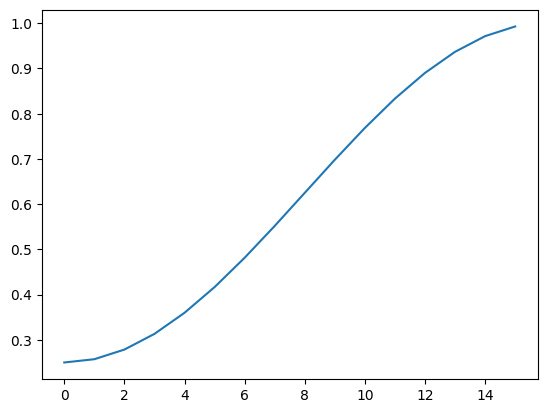

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# CosineAnnealingAlpha
def nt(nmin,nmax,tcur,tmax):
    return (nmax - .5*(nmax-nmin)*(1+np.cos(tcur*np.pi/tmax))).astype(np.float32)

# plt.plot(nt(.25,1,np.arange(EPOCHS),EPOCHS))
# plt.show()

# callback to update alpha during training
def cb(self):
    alpha = torch.as_tensor(nt(.25,1,learn.train_iter,EPOCHS*n_iter))
    learn.dls.train_ds.alpha = alpha
alpha_cb = Callback(before_batch=cb)

def augment_image(image):
#   Randomly rotate the image.
    angle = torch.as_tensor(random.uniform(-ANGLE, ANGLE))
    image = torchvision.transforms.functional.rotate(
        image,angle.item(),
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR
    )
    return image

In [4]:
lforaminal = [
    'left_neural_foraminal_narrowing_l1_l2',
    'left_neural_foraminal_narrowing_l2_l3',
    'left_neural_foraminal_narrowing_l3_l4',
    'left_neural_foraminal_narrowing_l4_l5',
    'left_neural_foraminal_narrowing_l5_s1'
]
rforaminal = [
    'right_neural_foraminal_narrowing_l1_l2',
    'right_neural_foraminal_narrowing_l2_l3',
    'right_neural_foraminal_narrowing_l3_l4',
    'right_neural_foraminal_narrowing_l4_l5',
    'right_neural_foraminal_narrowing_l5_s1'
]
labels = {
    'Normal/Mild':0,
    'Moderate':1,
    'Severe':2,
    'UNK':-100
}
coor = [
    'x_L1L2',
    'y_L1L2',
    'x_L2L3',
    'y_L2L3',
    'x_L3L4',
    'y_L3L4',
    'x_L4L5',
    'y_L4L5',
    'x_L5S1',
    'y_L5S1'
]

In [5]:
train = pd.read_csv(DATA_PATH + '/train_split.csv')
train = train[['study_id','fold']+lforaminal+rforaminal][train[lforaminal+rforaminal].isna().sum(1) < len(lforaminal+rforaminal)].reset_index(drop=True)
train.tail()

,study_id,fold,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1
1968,4282019580,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Severe
1969,4283570761,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1970,4284048608,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1971,4287160193,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4290709089,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [6]:
train = train.fillna('UNK')
train[(train[lforaminal+rforaminal] == 'UNK').sum(1)>0].reset_index(drop=True).tail()

,study_id,fold,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1
1,482624307,1.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,UNK,UNK,UNK,UNK,UNK
2,779042451,1.0,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,UNK,UNK,UNK,UNK,UNK
3,2507107985,3.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,UNK,UNK,UNK,UNK,UNK
4,2607462358,4.0,Normal/Mild,Moderate,Severe,Severe,Severe,UNK,UNK,UNK,UNK,UNK
5,3781188430,5.0,Normal/Mild,Moderate,Severe,Moderate,Normal/Mild,UNK,UNK,UNK,UNK,UNK


In [7]:
df_coor = pd.read_csv(DATA_PATH + '/train_label_coordinates.csv')
df_coor.tail()

,study_id,series_id,instance_number,condition,level,x,y
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333
48691,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L5/S1,211.813953,259.534884


In [8]:
L_coor = df_coor[df_coor.condition == 'Left Neural Foraminal Narrowing'].groupby(['study_id','series_id','level']).mean()
L_coor.tail()

instance_number           x           y
study_id   series_id  level                                         
4290709089 4237840455 L1/L2             11.0  219.465940   97.831063
                      L2/L3             12.0  205.340599  140.207084
                      L3/L4             12.0  202.724796  181.013624
                      L4/L5             12.0  202.933333  219.733333
                      L5/S1             12.0  211.813953  259.534884

In [9]:
R_coor = df_coor[df_coor.condition == 'Right Neural Foraminal Narrowing'].groupby(['study_id','series_id','level']).mean()
R_coor.tail()

instance_number           x           y
study_id   series_id  level                                         
4290709089 4237840455 L1/L2              5.0  219.405706   95.459321
                      L2/L3              4.0  208.106799  140.203404
                      L3/L4              4.0  204.195639  182.791594
                      L4/L5              4.0  208.381925  222.922987
                      L5/S1              4.0  215.268102  261.657732

In [10]:
F_coor =L_coor.merge(
    R_coor,
    left_on=L_coor.index.to_numpy(),
    right_on=R_coor.index.to_numpy(),
    suffixes=('_L','_R')
)
F_coor['study_id'] = F_coor['key_0'].apply(lambda v:v[0])
F_coor['series_id'] = F_coor['key_0'].apply(lambda v:v[1])
F_coor['level'] = F_coor['key_0'].apply(lambda v:v[2])
F_coor = F_coor.drop(columns=['key_0'])
F_coor.tail()

,instance_number_L,x_L,y_L,instance_number_R,x_R,y_R,study_id,series_id,level
9819,11.0,219.465940,97.831063,5.0,219.405706,95.459321,4290709089,4237840455,L1/L2
9820,12.0,205.340599,140.207084,4.0,208.106799,140.203404,4290709089,4237840455,L2/L3
9821,12.0,202.724796,181.013624,4.0,204.195639,182.791594,4290709089,4237840455,L3/L4
9822,12.0,202.933333,219.733333,4.0,208.381925,222.922987,4290709089,4237840455,L4/L5
9823,12.0,211.813953,259.534884,4.0,215.268102,261.657732,4290709089,4237840455,L5/S1


In [11]:
F_coor['instance_number_L'] = F_coor['instance_number_L'] - 1
F_coor['instance_number_R'] = F_coor['instance_number_R'] - 1
F_coor['instance_number'] = (F_coor['instance_number_L'] + F_coor['instance_number_R'])/2
F_coor['x'] = (F_coor['x_L'] + F_coor['x_R'])/2
F_coor['y'] = (F_coor['y_L'] + F_coor['y_R'])/2
F_coor.tail()

,instance_number_L,x_L,y_L,instance_number_R,x_R,y_R,study_id,series_id,level,instance_number,x,y
9819,10.0,219.465940,97.831063,4.0,219.405706,95.459321,4290709089,4237840455,L1/L2,7.0,219.435823,96.645192
9820,11.0,205.340599,140.207084,3.0,208.106799,140.203404,4290709089,4237840455,L2/L3,7.0,206.723699,140.205244
9821,11.0,202.724796,181.013624,3.0,204.195639,182.791594,4290709089,4237840455,L3/L4,7.0,203.460217,181.902609
9822,11.0,202.933333,219.733333,3.0,208.381925,222.922987,4290709089,4237840455,L4/L5,7.0,205.657629,221.328160
9823,11.0,211.813953,259.534884,3.0,215.268102,261.657732,4290709089,4237840455,L5/S1,7.0,213.541028,260.596308


In [12]:
coordinates = {}
for study_id,df in F_coor.groupby('study_id'):
    coordinates[study_id] = {}
for (study_id,series_id),df in tqdm(F_coor.groupby(['study_id','series_id'])):
    coordinates[study_id][series_id] = {
                'L1/L2':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'L':torch.nan,
                    'R':torch.nan,
                    'instance_number':torch.nan
                },
                    'L2/L3':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'L':torch.nan,
                    'R':torch.nan,
                    'instance_number':torch.nan
                },
                'L3/L4':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'L':torch.nan,
                    'R':torch.nan,
                    'instance_number':torch.nan
                },
                'L4/L5':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'L':torch.nan,
                    'R':torch.nan,
                    'instance_number':torch.nan
                },
                'L5/S1':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'L':torch.nan,
                    'R':torch.nan,
                    'instance_number':torch.nan
                }
    }
    
    for i in range(len(df)):
        row = df.iloc[i]
        coordinates[row['study_id']][row['series_id']][row['level']]['x'] = row['x']
        coordinates[row['study_id']][row['series_id']][row['level']]['y'] = row['y']
        coordinates[row['study_id']][row['series_id']][row['level']]['L'] = row['instance_number_L']
        coordinates[row['study_id']][row['series_id']][row['level']]['R'] = row['instance_number_R']
        coordinates[row['study_id']][row['series_id']][row['level']]['instance_number'] = row['instance_number']

100%|██████████| 1965/1965 [00:01<00:00, 1464.03it/s]


In [13]:
F_coor =  F_coor[[
    'study_id',
    'series_id'
]].groupby([
    'study_id',
    'series_id'
]).count().reset_index()
F_coor.tail()

,study_id,series_id
1960,4282019580,3029774733
1961,4283570761,2708429184
1962,4284048608,1875151370
1963,4287160193,327893304
1964,4290709089,4237840455


In [14]:
v = np.zeros((len(F_coor),25))
for i in tqdm(range(len(F_coor))):
    row = F_coor.iloc[i]
    k = 0
    for level in coordinates[row['study_id']][row['series_id']]:
        v[i,k:k+5] = list(coordinates[row['study_id']][row['series_id']][level].values())
        k += 5

100%|██████████| 1965/1965 [00:00<00:00, 9964.87it/s]


In [15]:
F_coor[[
    'x_L1L2',
    'y_L1L2',
    'L_L1L2',
    'R_L1L2',
    'M_L1L2',
    'x_L2L3',
    'y_L2L3',
    'L_L2L3',
    'R_L2L3',
    'M_L2L3',
    'x_L3L4',
    'y_L3L4',
    'L_L3L4',
    'R_L3L4',
    'M_L3L4',
    'x_L4L5',
    'y_L4L5',
    'L_L4L5',
    'R_L4L5',
    'M_L4L5',
    'x_L5S1',
    'y_L5S1',
    'L_L5S1',
    'R_L5S1',
    'M_L5S1',
]] = v
F_coor.tail()

,study_id,series_id,x_L1L2,y_L1L2,L_L1L2,R_L1L2,M_L1L2,x_L2L3,y_L2L3,L_L2L3,...,x_L4L5,y_L4L5,L_L4L5,R_L4L5,M_L4L5,x_L5S1,y_L5S1,L_L5S1,R_L5S1,M_L5S1
1960,4282019580,3029774733,290.326043,128.454469,6.0,13.0,9.5,266.577092,188.668253,6.0,...,245.436258,308.409819,6.0,15.0,10.5,252.349276,358.868668,6.0,15.0,10.5
1961,4283570761,2708429184,274.188462,177.692184,11.0,5.0,8.0,262.454607,227.049900,11.0,...,249.926376,319.963923,12.0,4.0,8.0,262.561141,361.475809,11.0,3.0,7.0
1962,4284048608,1875151370,222.121287,144.599926,13.0,5.0,9.0,208.473027,194.367397,13.0,...,197.188796,298.986350,16.0,5.0,10.5,208.375517,344.849449,16.0,5.0,10.5
1963,4287160193,327893304,190.034833,111.728635,3.0,9.0,6.0,178.330909,149.032637,3.0,...,182.114497,225.401787,3.0,11.0,7.0,197.413992,262.627865,3.0,11.0,7.0
1964,4290709089,4237840455,219.435823,96.645192,10.0,4.0,7.0,206.723699,140.205244,11.0,...,205.657629,221.328160,11.0,3.0,7.0,213.541028,260.596308,11.0,3.0,7.0


In [16]:
F = F_coor.merge(train,left_on='study_id',right_on='study_id')
F.tail()

,study_id,series_id,x_L1L2,y_L1L2,L_L1L2,R_L1L2,M_L1L2,x_L2L3,y_L2L3,L_L2L3,...,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1
1960,4282019580,3029774733,290.326043,128.454469,6.0,13.0,9.5,266.577092,188.668253,6.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Severe
1961,4283570761,2708429184,274.188462,177.692184,11.0,5.0,8.0,262.454607,227.049900,11.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1962,4284048608,1875151370,222.121287,144.599926,13.0,5.0,9.0,208.473027,194.367397,13.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1963,4287160193,327893304,190.034833,111.728635,3.0,9.0,6.0,178.330909,149.032637,3.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1964,4290709089,4237840455,219.435823,96.645192,10.0,4.0,7.0,206.723699,140.205244,11.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [17]:
mask = F[[
    'x_L1L2',
    'x_L2L3',
    'x_L3L4',
    'x_L4L5',
    'x_L5S1'
]].isna().values
mask += F[[
    'y_L1L2',
    'y_L2L3',
    'y_L3L4',
    'y_L4L5',
    'y_L5S1'
]].isna().values
mask += F[[
    'L_L1L2',
    'L_L2L3',
    'L_L3L4',
    'L_L4L5',
    'L_L5S1'
]].isna().values
mask += F[[
    'R_L1L2',
    'R_L2L3',
    'R_L3L4',
    'R_L4L5',
    'R_L5S1'
]].isna().values
mask += F[[
    'M_L1L2',
    'M_L2L3',
    'M_L3L4',
    'M_L4L5',
    'M_L5S1'
]].isna().values
mask = mask > 0
mask[-5:]
v = F[lforaminal].values
v[mask] = 'UNK'
F[lforaminal] = v
v = F[rforaminal].values
v[mask] = 'UNK'
F[rforaminal] = v

In [18]:
F['flipped_L1L2'] = F['L_L1L2'] < F['R_L1L2']
F['flipped_L2L3'] = F['L_L2L3'] < F['R_L2L3']
F['flipped_L3L4'] = F['L_L3L4'] < F['R_L3L4']
F['flipped_L4L5'] = F['L_L4L5'] < F['R_L4L5']
F['flipped_L5S1'] = F['L_L5S1'] < F['R_L5S1']
F['flipped'] = F[[
    'flipped_L1L2',
    'flipped_L2L3',
    'flipped_L3L4',
    'flipped_L4L5',
    'flipped_L5S1'
]].sum(1)

In [19]:
F[[
    'L_L1L2','R_L1L2',
    'L_L2L3','R_L2L3',
    'L_L3L4','R_L3L4',
    'L_L4L5','R_L4L5',
    'L_L5S1','R_L5S1',
    'flipped'
]][~F['flipped'].isin([0,5])]

,L_L1L2,R_L1L2,L_L2L3,R_L2L3,L_L3L4,R_L3L4,L_L4L5,R_L4L5,L_L5S1,R_L5S1,flipped
169,11.0,12.0,12.0,12.0,13.0,12.0,13.0,13.0,13.0,12.0,1
1086,12.0,12.0,12.0,12.0,12.0,13.0,13.0,13.0,13.0,13.0,1
1805,5.0,11.0,5.0,12.0,NaN,NaN,3.0,11.0,3.0,11.0,4


In [20]:
F = F[F['flipped'].isin([0,5])].drop(columns=[
    'flipped_L1L2',
    'flipped_L2L3',
    'flipped_L3L4',
    'flipped_L4L5',
    'flipped_L5S1'
])
F['flipped'] = F['flipped'] > 0
F.tail()

,study_id,series_id,x_L1L2,y_L1L2,L_L1L2,R_L1L2,M_L1L2,x_L2L3,y_L2L3,L_L2L3,...,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,flipped
1960,4282019580,3029774733,290.326043,128.454469,6.0,13.0,9.5,266.577092,188.668253,6.0,...,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Severe,True
1961,4283570761,2708429184,274.188462,177.692184,11.0,5.0,8.0,262.454607,227.049900,11.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,False
1962,4284048608,1875151370,222.121287,144.599926,13.0,5.0,9.0,208.473027,194.367397,13.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,False
1963,4287160193,327893304,190.034833,111.728635,3.0,9.0,6.0,178.330909,149.032637,3.0,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,True
1964,4290709089,4237840455,219.435823,96.645192,10.0,4.0,7.0,206.723699,140.205244,11.0,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,False


In [21]:
F.groupby('fold').count()

,study_id,series_id,x_L1L2,y_L1L2,L_L1L2,R_L1L2,M_L1L2,x_L2L3,y_L2L3,L_L2L3,...,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,flipped
fold,,,,,,,,,,,,,,,,,,,,,
1.0,393,393,393,393,393,393,393,393,393,393,...,393,393,393,393,393,393,393,393,393,393
2.0,394,394,394,394,394,394,394,394,394,394,...,394,394,394,394,394,394,394,394,394,394
3.0,392,392,392,392,392,392,392,392,392,392,...,392,392,392,392,392,392,392,392,392,392
4.0,389,389,389,389,389,389,389,389,389,389,...,389,389,389,389,389,389,389,389,389,389
5.0,394,394,394,394,394,394,394,394,394,394,...,394,394,394,394,394,394,394,394,394,394


In [22]:
class Sagittal_T1_foraminal_Dataset(Dataset):
    def __init__(self, df, VALID=False, P=patch_size, alpha=0):
        self.data = df
        self.VALID = VALID
        self.P = P
        self.alpha = alpha
        self.resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        
        
        sample = TRAIN_PATH + str(row['study_id']) + '/'+str(row['series_id'])

        images = [x.replace('\\','/') for x in glob.glob(sample+'/*.dcm')]
        images.sort(reverse=False, key=lambda x: int(x.split('/')[-1].replace('.dcm', '')))

        LR = row[[
            'L_L1L2','R_L1L2',
            'L_L2L3','R_L2L3',
            'L_L3L4','R_L3L4',
            'L_L4L5','R_L4L5',
            'L_L5S1','R_L5S1'
        ]].values.reshape(5,2)
        M = row[[
            'M_L1L2',
            'M_L2L3',
            'M_L3L4',
            'M_L4L5',
            'M_L5S1'
        ]].values

        label = torch.as_tensor([labels[x] for x in row[lforaminal+rforaminal]]).view(2,5).to(device)

        if row['flipped']:
            LR = np.flip(LR,1)
            label = label.flip(0)

        image = torch.stack([
            torch.as_tensor(pydicom.dcmread(x).pixel_array.astype(np.float32)) for x in images
        ]).float().to(device)
        image = image/image.max()
        D,H,W = image.shape

        c = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
        missing = c.isnan().sum(1) > 0
        c[missing] = 0

        if H > W:
            d = W
            h = (H - d)//2
            image = image[:,h:h+d]
            c[:,1] -= h
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            image = image[:,:,w:w+d]
            c[:,0] -= w
            W = H

        image = self.resize(image)
        image = nn.functional.pad(image,[self.P]*4,'reflect')
        c[:,1] = c[:,1]*PATCH_H/H + self.P
        c[:,0] = c[:,0]*PATCH_W/W + self.P
        c = c.long()

        crops = torch.stack([
            image[
                :,
                xy[1]-self.P:xy[1]+self.P,
                xy[0]-self.P:xy[0]+self.P
            ] for xy in c
        ])

        image = torch.zeros(2,5,Lmax,2*self.P,2*self.P).to(device)
        slices_mask = torch.ones(2,5,Lmax).bool().to(device)
        for i in range(5):
            if ~missing[i]:
                left_start = int(M[i]) + 1
                left_end = min([D,left_start + Lmax])
                left_crop = crops[i,left_start:left_end]

                right_end = int(M[i])
                right_start = max([0,right_end - Lmax])
                right_crop = crops[i,right_start:right_end]

                image[0,i,:len(left_crop)] = left_crop
                image[1,i,:len(right_crop)] = right_crop.flip(0)

                slices_mask[0,i,:len(left_crop)] = False
                slices_mask[1,i,:len(right_crop)] = False

                if not self.VALID:
                    image[:,i] = augment_image(image[:,i].reshape(-1,2*self.P,2*self.P)).reshape(2,Lmax,2*self.P,2*self.P)
            
        image = image[:,:,:,self.P//2:self.P//2+self.P,self.P//2:self.P//2+self.P]

        return [image,slices_mask],label

In [23]:
ds = Sagittal_T1_foraminal_Dataset(F)

tensor([[0, 0, 0, 0, 0],

        [0, 0, 0, 0, 0]], device='cuda:0')


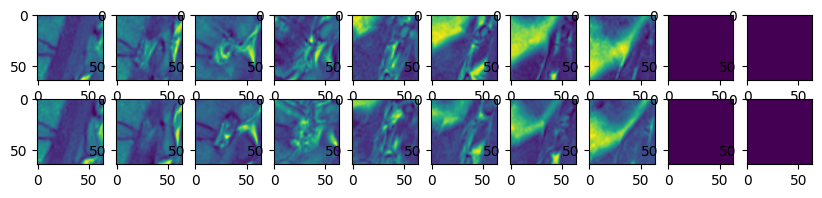

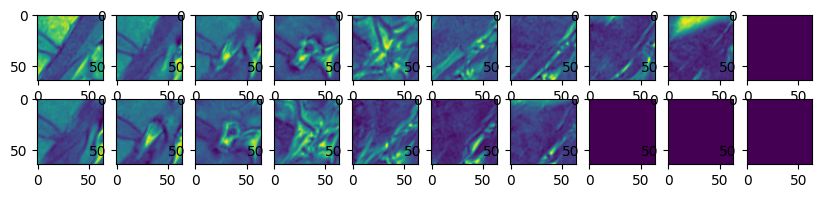

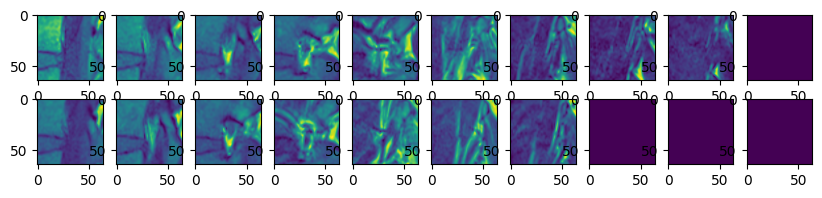

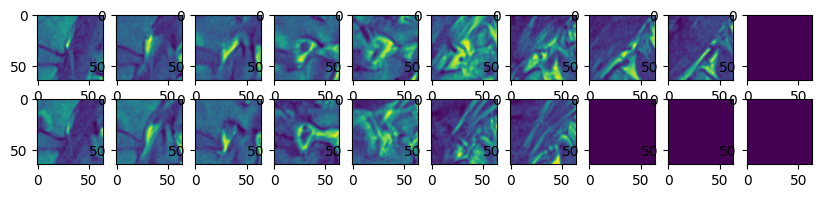

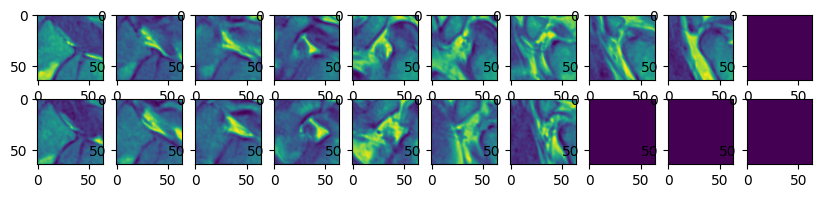

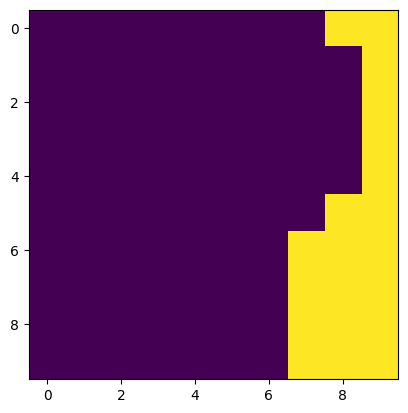

In [24]:
[sample,mask],label = ds.__getitem__(np.random.randint(len(ds)))
print(label)
for k in range(5):
    fig, axes = plt.subplots(2, Lmax, figsize=(10,2))
    for i in range(2):
        for j in range(Lmax):
            axes[i,j].imshow(sample.cpu()[i,k,j])
    plt.show()

plt.imshow(mask.cpu().view(-1,Lmax))

In [25]:
del ds
gc.collect()

44181

In [26]:
class Sagittal_T1_Foramina_Discriminator(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        CNN = torchvision.models.resnet18(weights='DEFAULT')
        W = nn.Parameter(CNN.conv1.weight.sum(1, keepdim=True))
        CNN.conv1 = nn.Conv2d(1, patch_size, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        CNN.conv1.weight = W
        CNN.fc = nn.Identity()
        self.emb = CNN.to(device)
        self.proj_out = nn.Linear(dim,2).to(device)
    
    def forward(self, x):        
        x = self.emb(x.view(-1,1,patch_size,patch_size))
        x = self.proj_out(x.view(-1,512))
        return x

In [27]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[...,None] * emb[None,...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class Sagittal_T1_Foraminal_ViT(nn.Module):
    def __init__(
            self,
            ENCODER,
            dim=512,
            depth=24,
            head_size=64
        ):
        super().__init__()
        self.ENCODER = ENCODER
        self.slices_enc = SinusoidalPosEmb(dim)(torch.arange(Lmax, device=device).unsqueeze(0))
        pos_enc = SinusoidalPosEmb(dim)(torch.arange(5, device=device).unsqueeze(0))
        self.pos_enc = nn.Parameter(pos_enc)
        self.slices_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.proj_out = nn.Linear(dim,3).to(device)
    
    def forward(self, x):
        x,slices_mask = x
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))

        x = x.view(-1,Lmax,512)
        x = x + self.slices_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])

        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        level_mask = (slices_mask.sum(1) == Lmax).view(-1,10)
        x = x.view(-1,10,512) + torch.concat([self.pos_enc,self.pos_enc],1)
        x = self.transformer(x,src_key_padding_mask=level_mask)
        x = self.proj_out(x.view(-1,512)).view(-1,2,5,3)
        return x

In [28]:
def myLoss(preds,target):
    target = target.view(-1)
    preds = preds.view(-1,3)
    
    return nn.CrossEntropyLoss(weight=torch.as_tensor([1.,2.,4.]).to(device))(preds,target)

epoch,train_loss,valid_loss,time
0,0.992564,0.791637,08:38
1,0.800446,0.709254,09:29
2,0.681497,0.666407,07:56
3,0.648018,0.678820,06:51
4,0.637472,0.640994,06:48
5,0.643129,0.548766,06:46
6,0.619013,0.583501,06:49
7,0.588112,0.548687,06:46
8,0.584016,0.579496,06:46
9,0.563971,0.546118,06:53


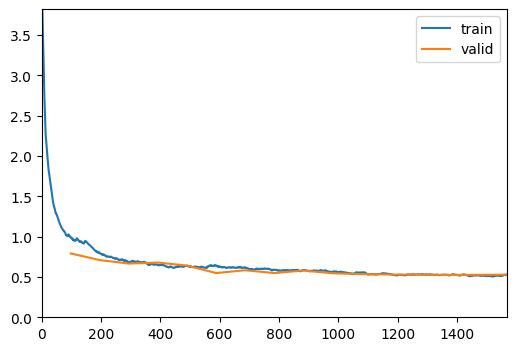

epoch,train_loss,valid_loss,time
0,1.076196,0.933677,07:01
1,0.834538,0.594666,06:54
2,0.763815,0.710850,06:51
3,0.701157,0.631858,06:52
4,0.673065,0.562541,06:49
5,0.647248,0.636648,06:50
6,0.647589,0.646851,06:49
7,0.625931,0.562499,06:48
8,0.588068,0.583961,06:48
9,0.576978,0.581187,06:48


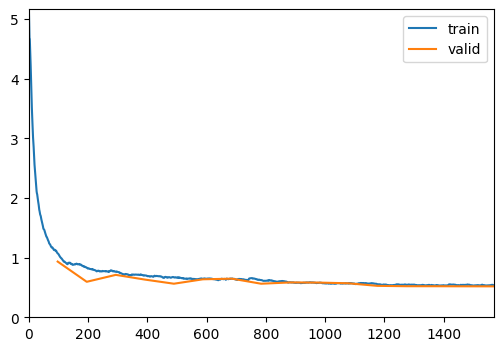

epoch,train_loss,valid_loss,time
0,0.951595,0.966077,06:49
1,0.763205,0.615699,06:47
2,0.684596,0.659295,06:47
3,0.648593,0.634360,06:46
4,0.651514,0.571689,06:49
5,0.687860,0.788637,06:45
6,0.620356,0.588153,06:46
7,0.582112,0.581115,06:48
8,0.567531,0.561421,06:48
9,0.564163,0.571180,06:48


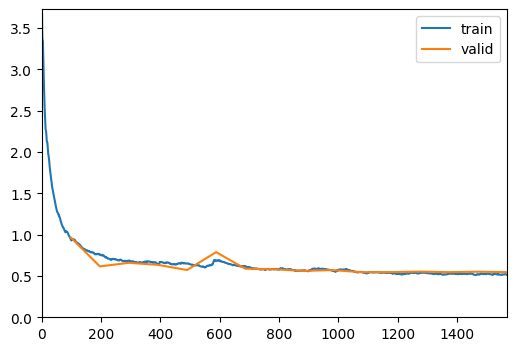

epoch,train_loss,valid_loss,time
0,1.032047,0.737022,06:47
1,0.795037,0.698807,06:47
2,0.738357,0.540468,06:58
3,0.728280,0.564394,06:58
4,0.675039,0.519859,07:08
5,0.650696,0.510627,07:04
6,0.611826,0.531489,07:00
7,0.603458,0.513235,07:02
8,0.605266,0.546934,07:01
9,0.581511,0.495691,07:06


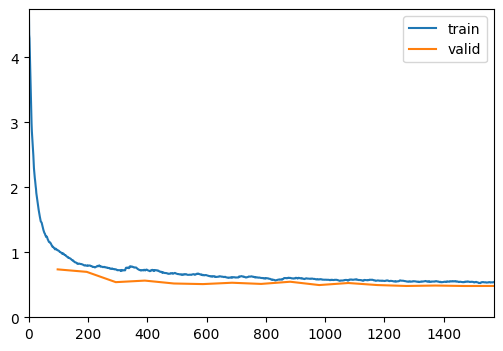

epoch,train_loss,valid_loss,time
0,0.956523,0.710800,06:49
1,0.817998,0.580511,06:49
2,0.707865,0.614283,06:49
3,0.655219,0.541865,06:49
4,0.647731,0.538263,07:27
5,0.643093,0.640717,07:17
6,0.620348,0.553628,06:49
7,0.608142,0.539150,06:49
8,0.598673,0.634044,06:47
9,0.570698,0.514110,06:50


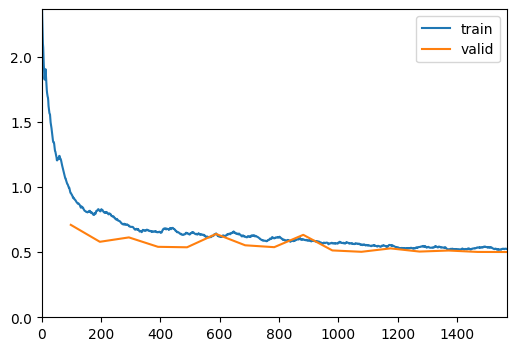

In [29]:
for f in FOLDS:
    seed_everything(SEED)
    model = Sagittal_T1_Foraminal_ViT(
        torch.load(PATH + 'Sagittal_T1/foraminal_prediction/discriminator/Sagittal_T1_foramina_discriminator_'+str(f)).emb
    )
    df = F
    tdf = df[df.fold != f]
    vdf = df[df.fold == f]
    tds = Sagittal_T1_foraminal_Dataset(tdf)
    vds = Sagittal_T1_foraminal_Dataset(vdf,VALID=True)
    tdl = torch.utils.data.DataLoader(tds, batch_size=BS, shuffle=True, drop_last=True)
    vdl = torch.utils.data.DataLoader(vds, batch_size=BS, shuffle=False)
    dls = DataLoaders(tdl,vdl)

    n_iter = len(tds)//BS

    learn = Learner(
        dls,
        model,
        loss_func=myLoss,
        cbs=[
            ShowGraphCallback(),
            GradientClip(3.0),
            alpha_cb
        ]
    )
    learn.fit_one_cycle(EPOCHS, lr_max=LR_MAX, wd=0.05, pct_start=0.02)
    torch.save(model,'Sagittal_T1_pretrained_foraminal_ViT_'+str(f))
    del model,df,tdf,vdf,tds,vds,tdl,vdl,dls,learn
    gc.collect()